# IN-DEPTH EDA AND ANSWERING ANALYTICAL QUESITONS

### Analytical Questions:
1. *Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year?
3. Did the earthquake impact sales?
4. Are certain groups of stores selling more products? (Cluster, city, state, type)
5. Are sales affected by promotions, oil prices and holidays?
6. *What analysis can we get from the date and its extractable features?
7. *What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

NB: starred questions is not answered with visualizations. Answers to them improves quality of data and analysis. 

outcomes:
- Insights on trends, patterns and relationships. useful for proposing recommendations, informed decision making during data cleaning, feature engineering etc.  
- Visualizations for powerbi deployment, article and reports. 
- Data cleaning steps obtained to create python script to automate cleaning. 

### Hypothesis  
HO: Sales are **NOT** significantly influenced by number of items on promotion

H1: Sales are significantly influenced by number of items on promotion

In [281]:
## Importations

import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 

import random
import datetime

In [2]:
## Load datasets
train = pd.read_csv("../data/raw/train.csv", 
                   dtype={
                       "store_nbr":"category", 
                       "family":"category",
                       "sales":"float64",
                        "id":"int32",
                        "onpromotion":"int32"
                       },
                   index_col=["date"], 
                   parse_dates=True)

test = pd.read_csv("../data/raw/test.csv", 
                   dtype={
                       "store_nbr":"category", 
                       "family":"category",
                       "sales":"float64",
                        "id":"int32",
                        "onpromotion":"int32"
                       },
                   index_col=["date"], 
                   parse_dates=True)

holiday_events = pd.read_csv("../data/raw/holiday_events.csv", 
                    dtype={
                        "type":"category",
                        "locale":"category",
                        "locale_name":"category",
                        "description":"category",
                        "transferred":bool
                    },
                    index_col=["date"], 
                    parse_dates=True, 
                    date_format="%Y-%m-%d")
holiday_events = holiday_events.drop(columns=holiday_events.columns[0])

oil = pd.read_csv("../data/processed/01_oil_further_analysis.csv", 
                    index_col=["date"], parse_dates=True, 
                    date_format="%Y-%m-%d" )

stores = pd.read_csv("../data/raw/stores.csv", 
                     dtype={"store_nbr":"category", 
                            "city":"category",
                            "state":"category",
                            "type":"category",
                            "cluster":"category"
                            },
                     index_col=0)

transactions = pd.read_csv("../data/raw/transactions.csv", 
                           dtype={"store_nbr":"category"},
                           index_col=["date"],
                           parse_dates=True)

## Exploration Data Analysis



### Univariate Analysis

In [10]:
train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [17]:
train.store_nbr.describe()

count     3000888
unique         54
top             1
freq        55572
Name: store_nbr, dtype: object

In [19]:
54 * 55572  # all 54 categories occurs the same number of times. 

3000888

In [20]:
train.family.describe()

count        3000888
unique            33
top       AUTOMOTIVE
freq           90936
Name: family, dtype: object

In [22]:
33 * 90936 # all 33 families occur same number of times. 

3000888

In [35]:
print("sales mean: ", train.sales.mean())
train.sales.describe(percentiles=[0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.75, 0.9]) # lots of sales values 0

sales mean:  357.77574911261894


count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
30%      0.000000e+00
35%      1.000000e+00
40%      3.000000e+00
50%      1.100000e+01
60%      3.600000e+01
70%      1.277660e+02
75%      1.958473e+02
90%      8.670000e+02
max      1.247170e+05
Name: sales, dtype: float64

- we see that sales data is greatly skewed to the right with large variablity.
- this is likely due to the heterogeneity in sales as sales is affected significantly by store properties and product family. 
- sales distribution for specific stores and family may be more informative. 

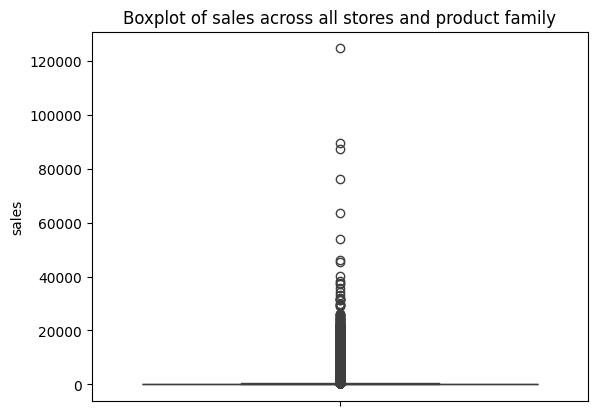

In [40]:
# visualize distribution
fig, ax = plt.subplots()

ax = sns.boxplot(train.sales); 
ax.set_title("Boxplot of sales across all stores and product family");

- outliers observed may not be true outliers since the data is

In [26]:
train.onpromotion.describe()

count    3.000888e+06
mean     2.602770e+00
std      1.221888e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.410000e+02
Name: onpromotion, dtype: float64

In [41]:
average_daily_sales = train.groupby(train.index)["sales"].mean()
average_daily_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390807
2013-01-03    202.840197
2013-01-04    198.911154
2013-01-05    267.873244
Name: sales, dtype: float64

In [66]:
## change default plotting settings

sns.set_style("whitegrid")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(20, 7),
    titleweight="bold",
    titlesize=18,
)

plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10
)

%config InlineBackend.figure_format = "retina" # increase resolution

plot_params = dict(
    style=".-",
    color="0.75",
    markerfacecolor="0.25",
    markeredgecolor="0.25",
)

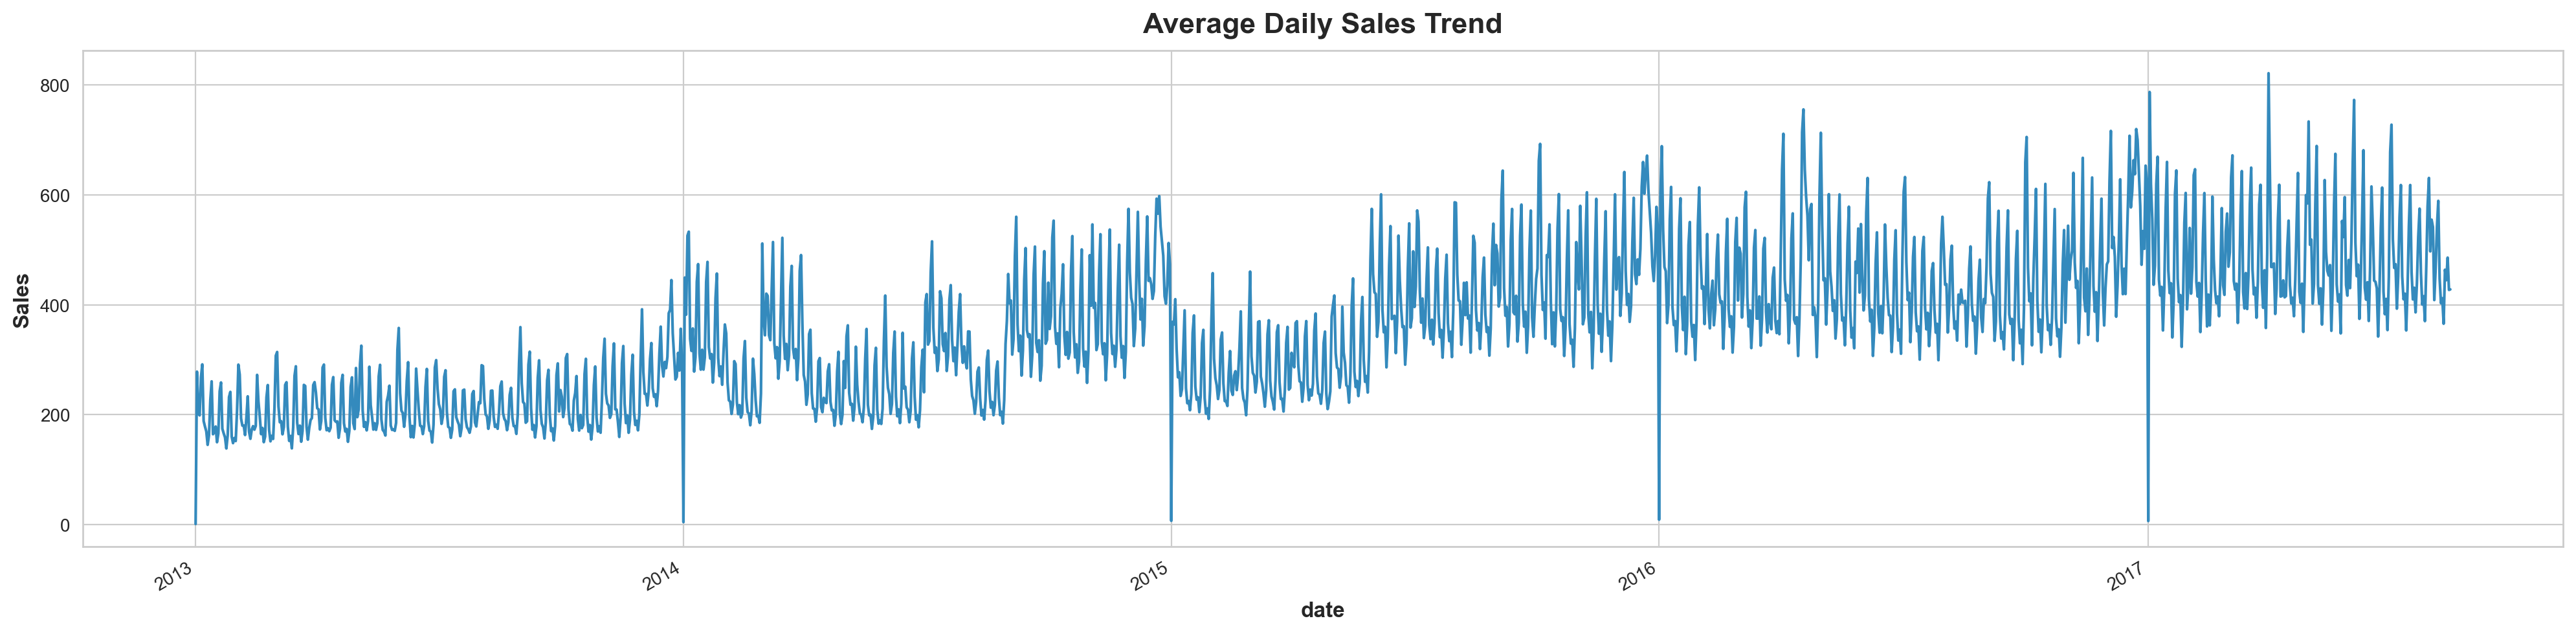

In [210]:
# trend visualization

fig, ax = plt.subplots()
average_daily_sales.plot(color="C1")
ax.set(title="Average Daily Sales Trend", ylabel="Sales");

by visual inspection, we see:
- an upward trend
- seasonality components of various frequencies

In [50]:
## compute moving average
moving_average = average_daily_sales.rolling(
    window=365, # series is daily observations; window size of 365 smooth out short-term fluctuations in series
    min_periods=183, # half of window size is okay. 
    center=True
).mean()

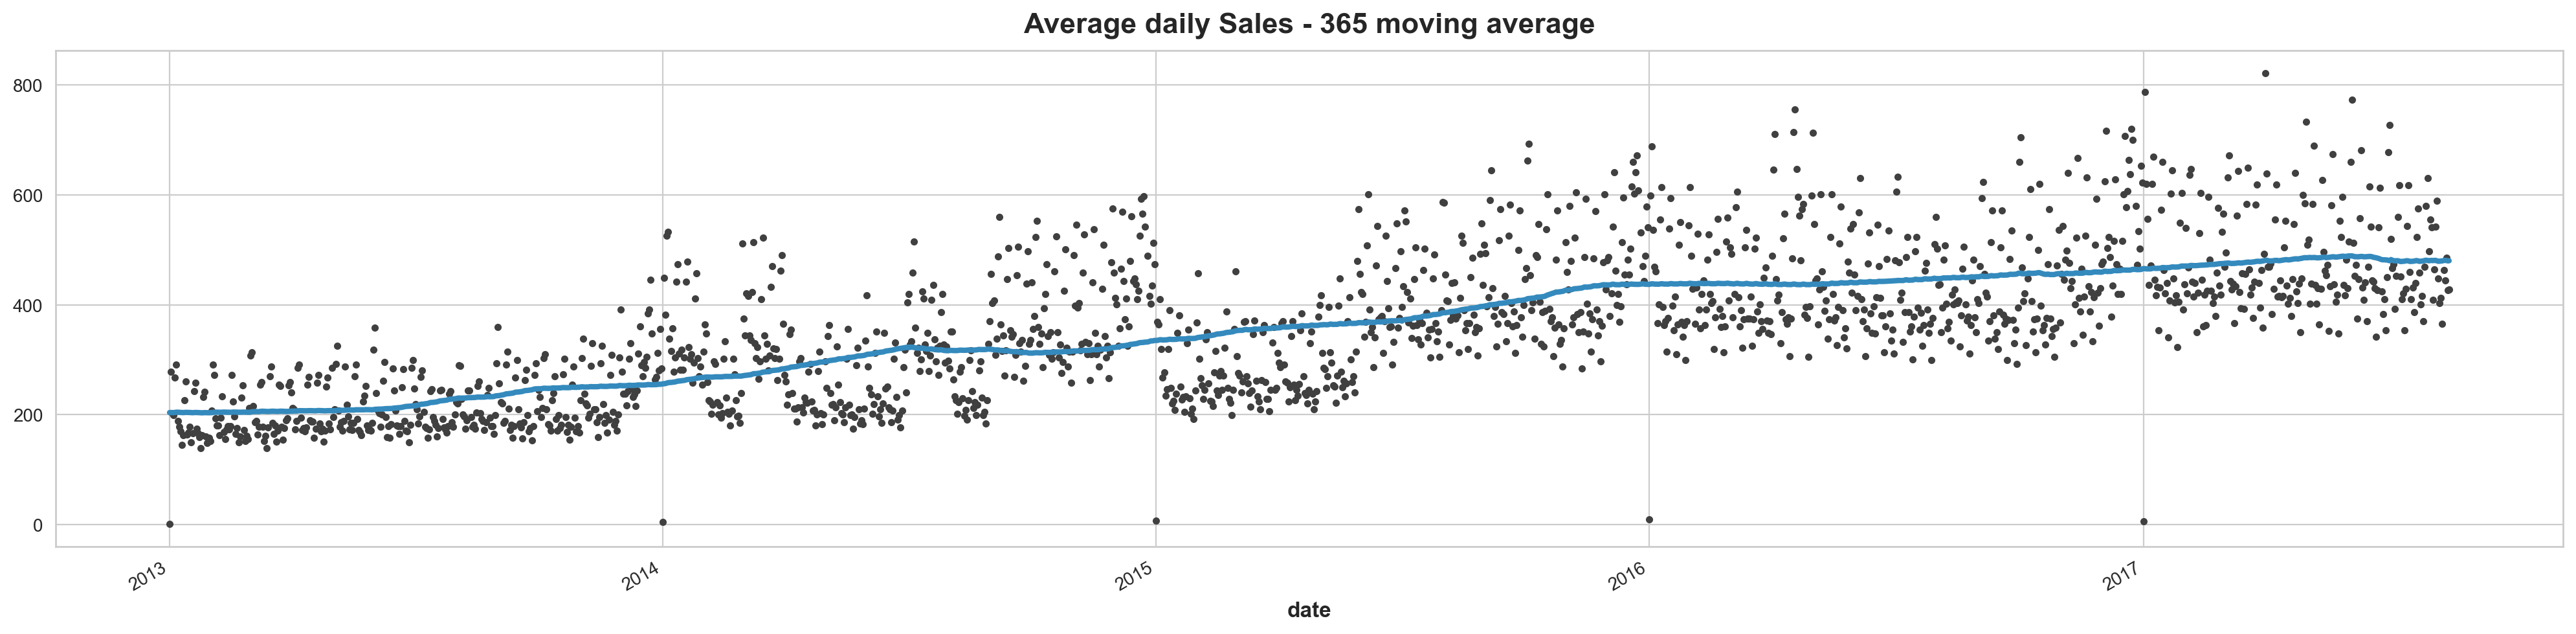

In [153]:
## moving average plot

ax = average_daily_sales.plot(style=".", color="0.25")
moving_average.plot(ax=ax, linewidth=3, title="Average daily Sales - 365 moving average", color="C1");

Our ultimate goal isn't to predict average daily sales but to predict sales for specified `store_nbr` and `family`  for a given day.  

### Multivariate Analysis 

In [138]:
## train data into multindex dataset

train = train.set_index(["store_nbr", "family"], append=True)
train.head()

id  sales  onpromotion
date       store_nbr family                            
2013-01-01 1         AUTOMOTIVE   0    0.0            0
                     BABY CARE    1    0.0            0
                     BEAUTY       2    0.0            0
                     BEVERAGES    3    0.0            0
                     BOOKS        4    0.0            0

In [70]:
train.index

MultiIndex([('2013-01-01', '1',                 'AUTOMOTIVE'),
            ('2013-01-01', '1',                  'BABY CARE'),
            ('2013-01-01', '1',                     'BEAUTY'),
            ('2013-01-01', '1',                  'BEVERAGES'),
            ('2013-01-01', '1',                      'BOOKS'),
            ('2013-01-01', '1',               'BREAD/BAKERY'),
            ('2013-01-01', '1',                'CELEBRATION'),
            ('2013-01-01', '1',                   'CLEANING'),
            ('2013-01-01', '1',                      'DAIRY'),
            ('2013-01-01', '1',                       'DELI'),
            ...
            ('2017-08-15', '9',                  'MAGAZINES'),
            ('2017-08-15', '9',                      'MEATS'),
            ('2017-08-15', '9',              'PERSONAL CARE'),
            ('2017-08-15', '9',               'PET SUPPLIES'),
            ('2017-08-15', '9',    'PLAYERS AND ELECTRONICS'),
            ('2017-08-15', '9',        

In [143]:
#series for store_nbr=1 and family=AUTOMOTIVE

train.loc[(slice(None), '1','AUTOMOTIVE')]

,id,sales,onpromotion
date,,,
2013-01-01,0,0.0,0
2013-01-02,1782,2.0,0
2013-01-03,3564,3.0,0
2013-01-04,5346,3.0,0
2013-01-05,7128,5.0,0
...,...,...,...
2017-08-11,2991978,1.0,0
2017-08-12,2993760,6.0,0
2017-08-13,2995542,1.0,0


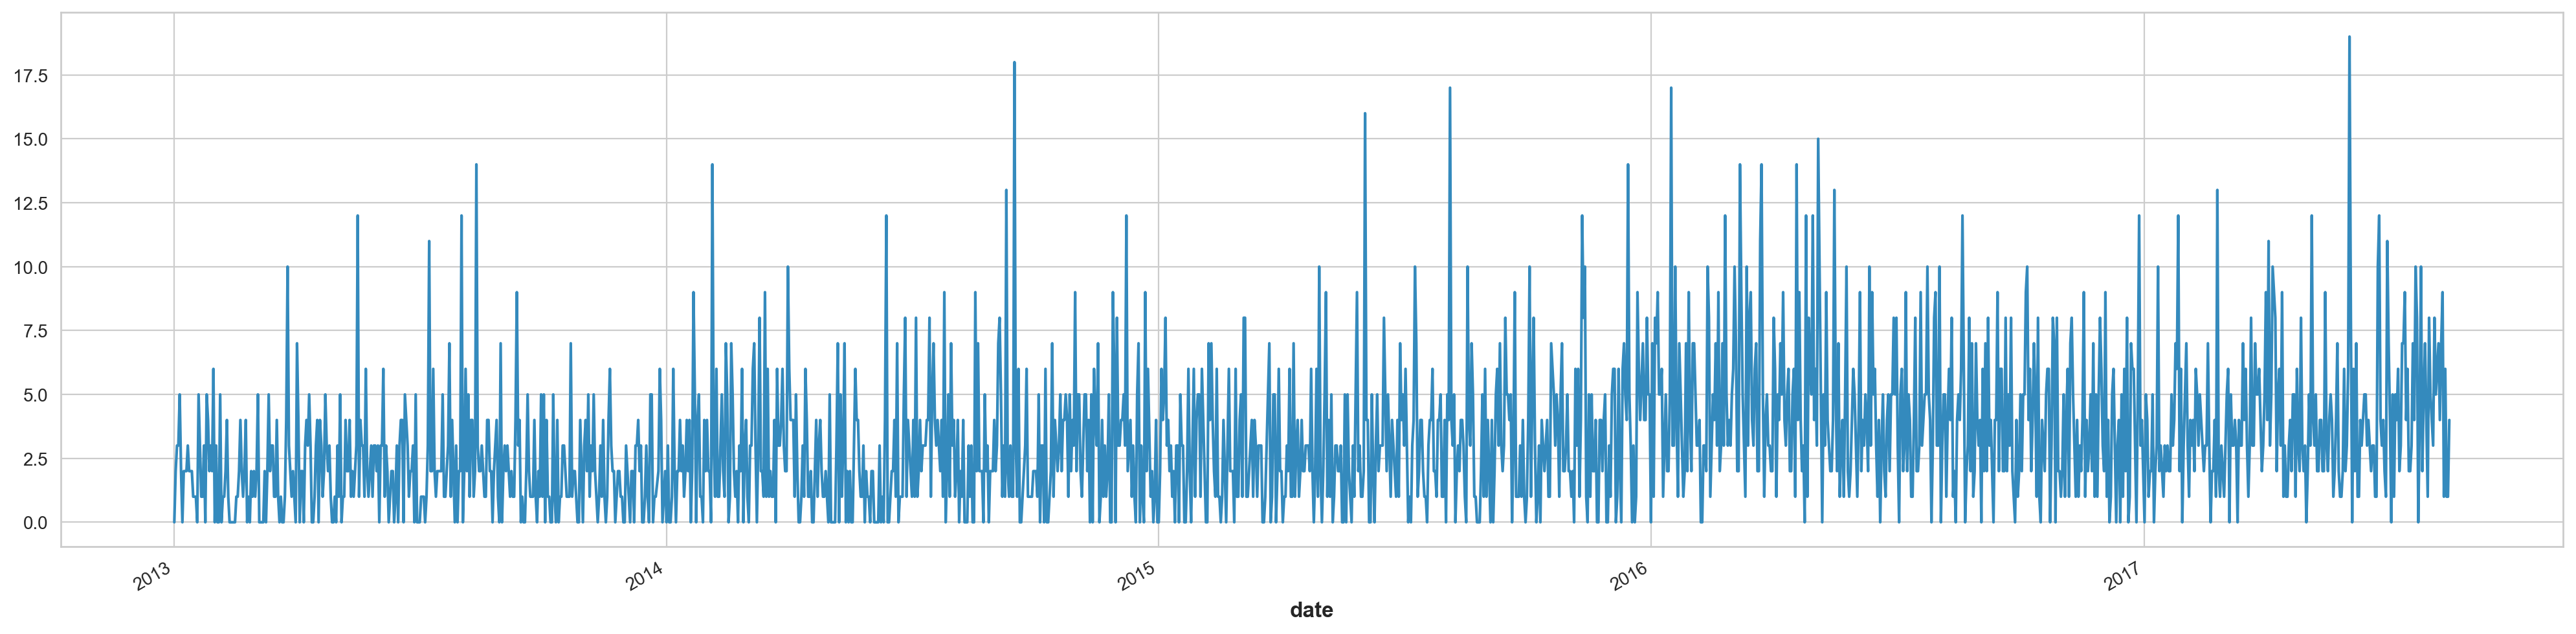

In [154]:
train.loc[(slice(None), '1','AUTOMOTIVE')]["sales"].plot(color="C1");

In [146]:
# all series

sales_series = train.unstack(["store_nbr", "family"])["sales"]
sales_series 

store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0      0.00000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0    470.65200   
2013-01-03        3.0       0.0    0.0     919.0   0.0    310.65500   
2013-01-04        3.0       0.0    3.0     953.0   0.0    198.36600   
2013-01-05        5.0       0.0    3.0    1160.0   0.0    301.05700   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

store_nbr                                        ...         9           \
family     CELEBRATION CLEANING  DAIRY     DELI  ... MAGAZINES    MEATS   
date                                             ...                      
2013-01-01         0.0      0.0    0.0    0.000  ...       0.0    0.000   
2013-01-02         0.0   1060.0  579.0  164.069  ...       0.0  374.531   
2013-01-03         0.0    836.0  453.0  151.582  ...       0.0  400.863   
2013-01-04         0.0    827.0  460.0  131.411  ...       0.0  310.878   
2013-01-05         0.0    811.0  464.0  118.613  ...       0.0  447.685   
...                ...      ...    ...      ...  ...       ...      ...   
2017-08-11         4.0    341.0  343.0   64.302  ...       5.0  309.245   
2017-08-12         3.0    351.0  526.0   99.488  ...       2.0  260.298   
2017-08-13         1.0    169.0  266.0   47.770  ...       3.0  327.206   
2017-08-14         4.0    571.0  699.0  154.578  ...      12.0  330.975   
2017-08-15        21.0    703.0  602.0  116.402  ...      11.0  449.228   

store_nbr                                                               \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS  POULTRY   
date                                                                     
2013-01-01           0.0          0.0                     0.0    0.000   
2013-01-02         482.0          0.0                     0.0  651.292   
2013-01-03         372.0          0.0                     0.0  509.496   
2013-01-04         324.0          0.0                     0.0  332.672   
2013-01-05         461.0          0.0                     0.0  510.919   
...                  ...          ...                     ...      ...   
2017-08-11         373.0         11.0                     2.0  525.224   
2017-08-12         400.0          7.0                    10.0  383.387   
2017-08-13         510.0          2.0                     9.0  412.458   
2017-08-14         445.0          2.0                    14.0  283.429   
2017-08-15         522.0          6.0                     6.0  438.133   

store_nbr                                                                  
family     PREPARED FOODS   PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                       
2013-01-01        0.00000     0.000                        0.0   0.000000  
2013-01-02       83.00000     0.000                        0.0  29.214000  
2013-01-03       66.00000     0.000                        0.0  25.000000  
2013-01-04       57.00000     0.000                        0.0  11.000000  
2013-01-05       84.00000     0.000                        0.0  28.361000  
...                   ...       ...                        ...        ...  
2017-08-11      112.10000  1453.078                      140.0  23.831000  
2017-08-12      129.90399  1419.264                      138.0  16.859001  
2017-08-13      105.16900  1693.607                      200.0  20.000000  
2017-

In [175]:
store_nbr_list = train.reset_index()["store_nbr"].unique()
family_list = train.reset_index()["family"].unique()

print(store_nbr_list)
print(family_list)

['1', '10', '11', '12', '13', ..., '54', '6', '7', '8', '9']
Length: 54
Categories (54, object): ['1', '10', '11', '12', ..., '6', '7', '8', '9']
['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', ..., 'POULTRY', 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']
Length: 33
Categories (33, object): ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', ..., 'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD']


In [205]:
# define function to plot randomly chosen series

def plot_series(num_of_plots=1, specific=False, store_nbr=1, family="AUTOMOTIVE"):
    
    if specific == False:
        for i in range(num_of_plots):
            store_nbr = random.choice(store_nbr_list) # choose a random store
            family = random.choice(family_list) # choose random product family
            
            
            fig, ax = plt.subplots()
            ax = sales_series[(store_nbr, family)].plot(color="C1")
            ax.set_ylabel("sales")
            ax.set_title(f"Time plot for {family} sales(store number {store_nbr})".title())
            
    if specific==True:
        fig, ax = plt.subplots()
        ax = sales_series[(store_nbr, family)].plot(color="C1")
        ax.set_ylabel("sales")
        ax.set_title(f"Time plot for {family} sales(store number {store_nbr})".title())


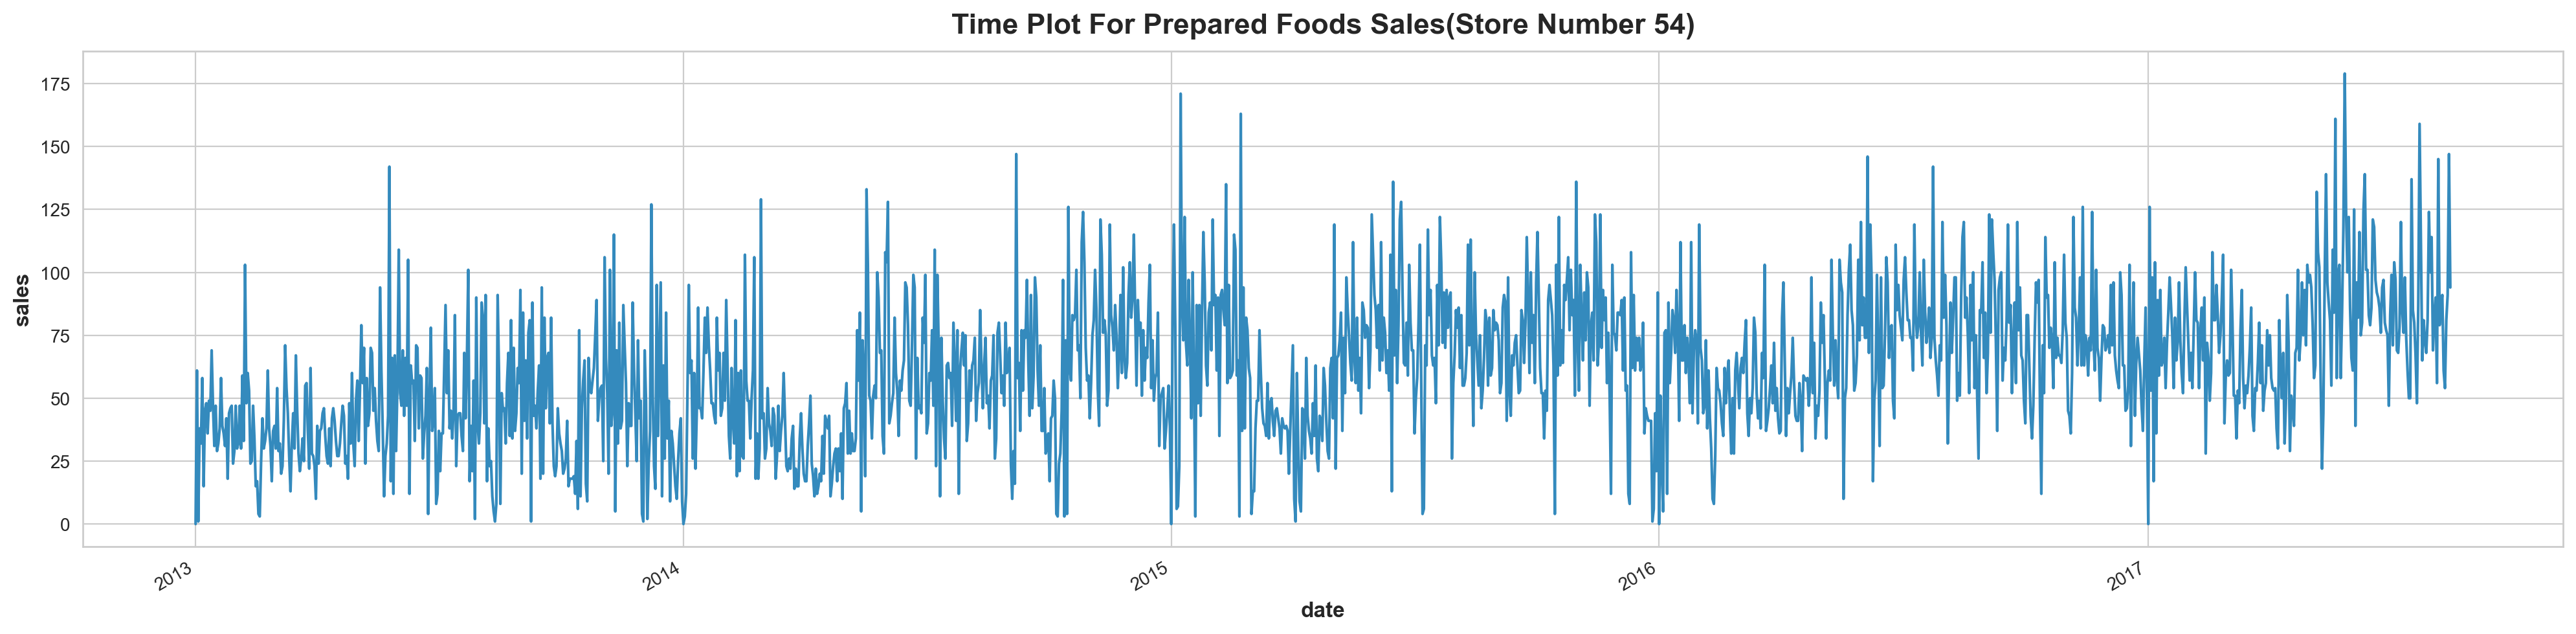

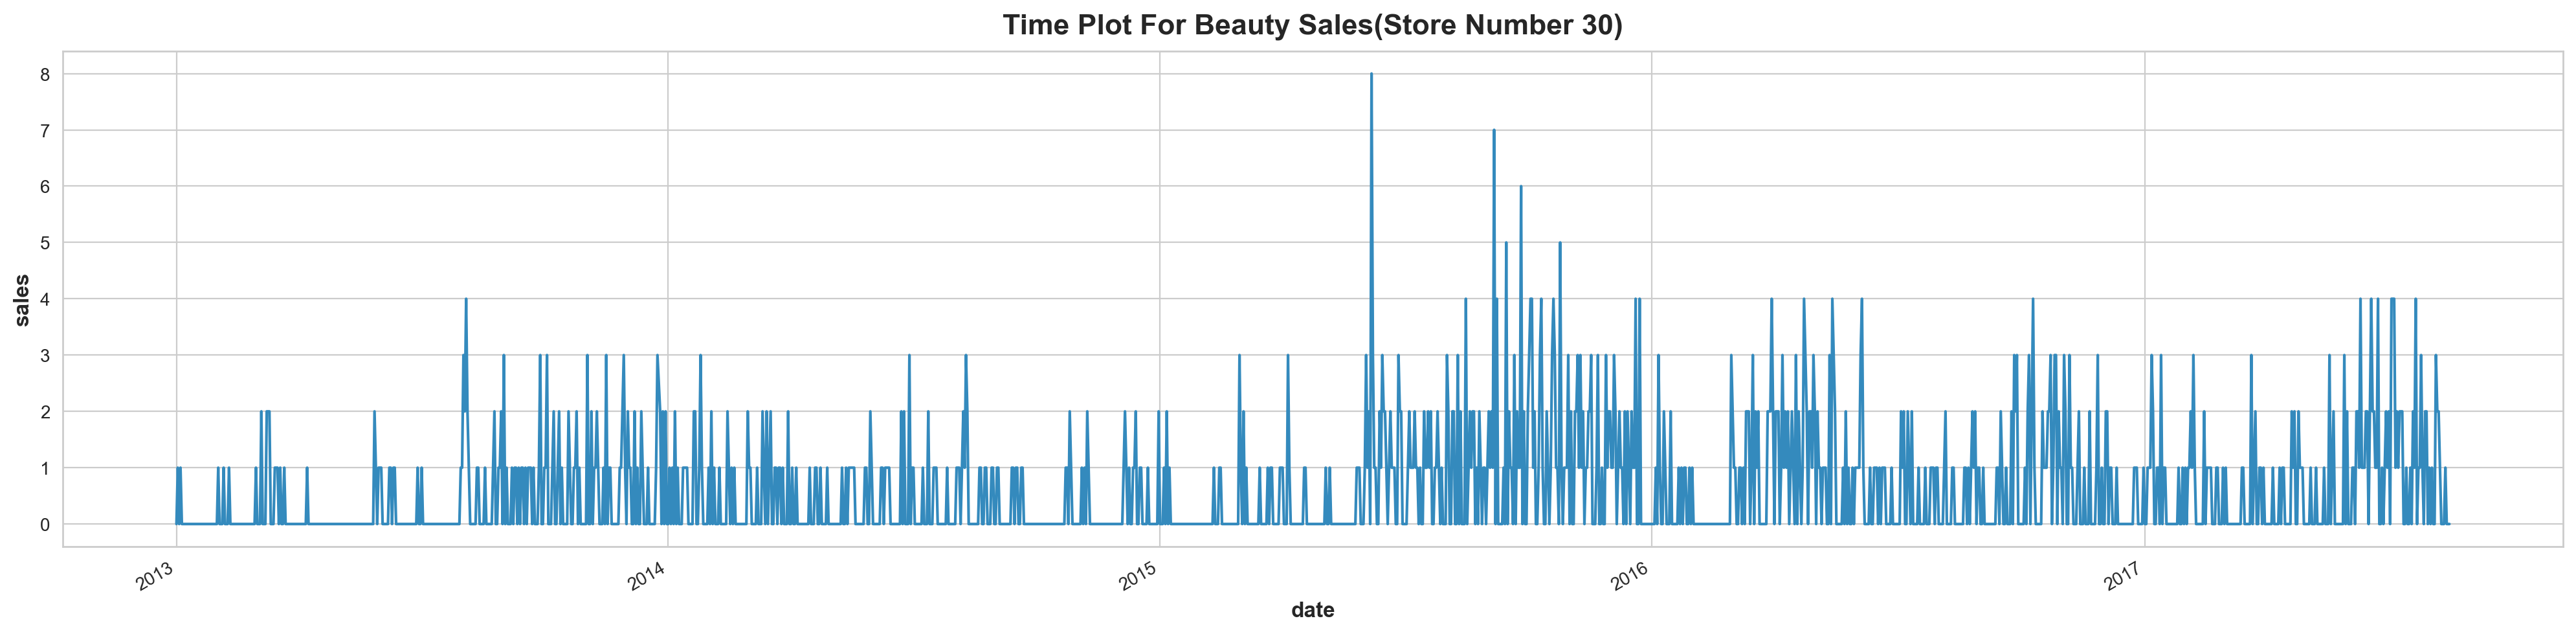

In [206]:
plot_series(num_of_plots=2)

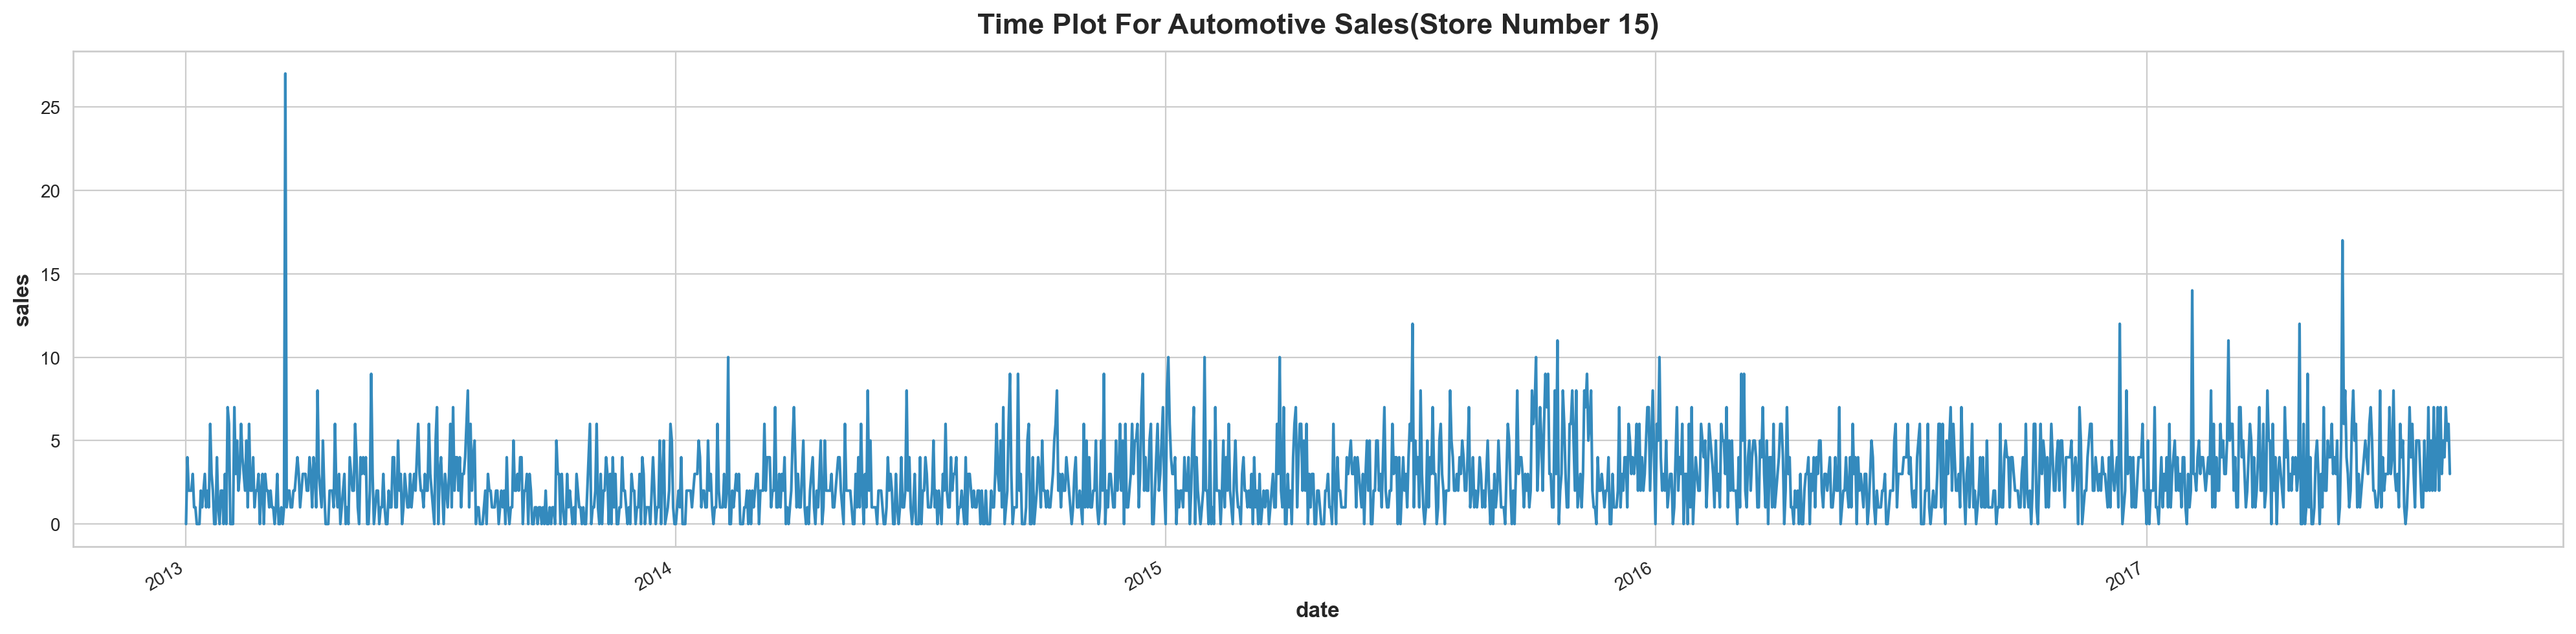

In [208]:
plot_series(specific=True, store_nbr="15", family="AUTOMOTIVE")

- cleary there's so much differences in the various plots for different product family. 
- this means that  `store_nbr` and `family` will be important in helping our ML model understand the differences the series and help predict more accurately.  
- we explore the structure of the daily average sales


In [6]:
total_daily_sales.groupby(total_daily_sales.index.year).min()

date
2013     2511.618999
2014     8602.065404
2015    12773.616980
2016    16433.394000
2017    12082.500997
Name: sales, dtype: float64

In [7]:
total_daily_sales.groupby(total_daily_sales.index.year).idxmin()

date
2013   2013-01-01
2014   2014-01-01
2015   2015-01-01
2016   2016-01-01
2017   2017-01-01
Name: sales, dtype: datetime64[ns]

# ANSWERING ANALYTICAL QUESTIONS WITH VISUALIZATIONS 

1. Which dates have the lowest and highest sales for each year?


In [9]:
## Lowest and Highest sales for each year

total_daily_sales = train.groupby(train.index)["sales"].sum()
print("Lowest sales day for each year: ")
lowest_sales_df = pd.DataFrame( {
    "Date":total_daily_sales.groupby(total_daily_sales.index.year).idxmin(), 
    "Lowest Sale":total_daily_sales.groupby(total_daily_sales.index.year).min()
}             
).reset_index(drop=True).set_index("Date")

lowest_sales_df

Lowest sales day for each year: 


,Lowest Sale
Date,
2013-01-01,2511.618999
2014-01-01,8602.065404
2015-01-01,12773.616980
2016-01-01,16433.394000
2017-01-01,12082.500997


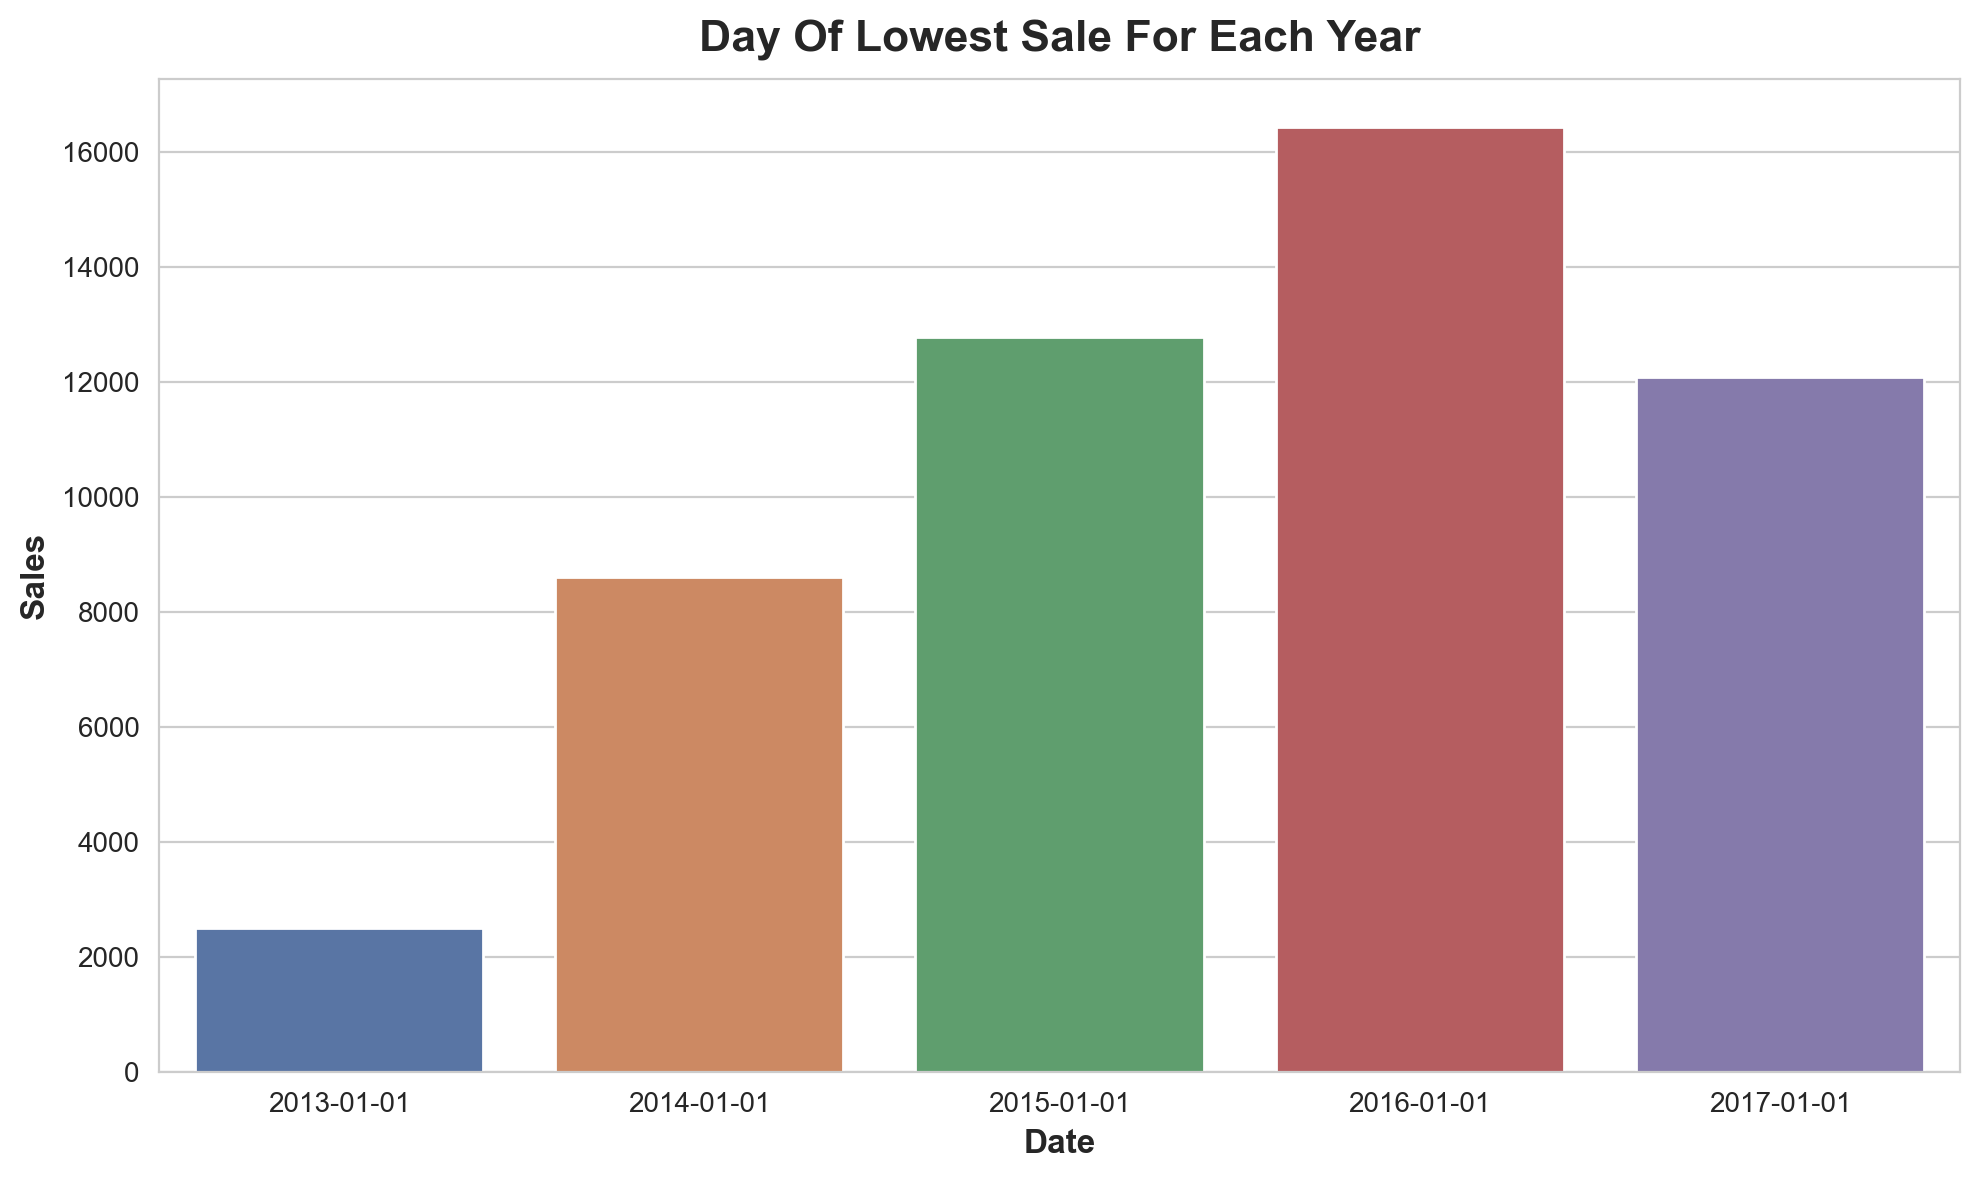

In [266]:
## plot lowest sales for each year

fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.barplot(
    x= lowest_sales_df.index, 
    y=lowest_sales_df["Lowest Sale"], 
    hue=lowest_sales_df.index, 
    palette="deep", legend=False
    )


#ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.set(title="Day of Lowest sale for each year".title(), ylabel="Sales")
plt.savefig("../reports/figures/lowest_sale_dates.png");



New year day consistently the lowest sale save

In [27]:
print("Highest sales day for each year: ")
highest_sale_df = pd.DataFrame( {
    "Date":total_daily_sales.groupby(total_daily_sales.index.year).idxmax(), 
    "Highest Sale":total_daily_sales.groupby(total_daily_sales.index.year).max()
}             
).reset_index(drop=True).set_index("Date")
highest_sale_df

Highest sales day for each year: 


,Highest Sale
Date,
2013-12-23,7.928653e+05
2014-12-23,1.064978e+06
2015-10-04,1.234131e+06
2016-04-18,1.345921e+06
2017-04-01,1.463084e+06


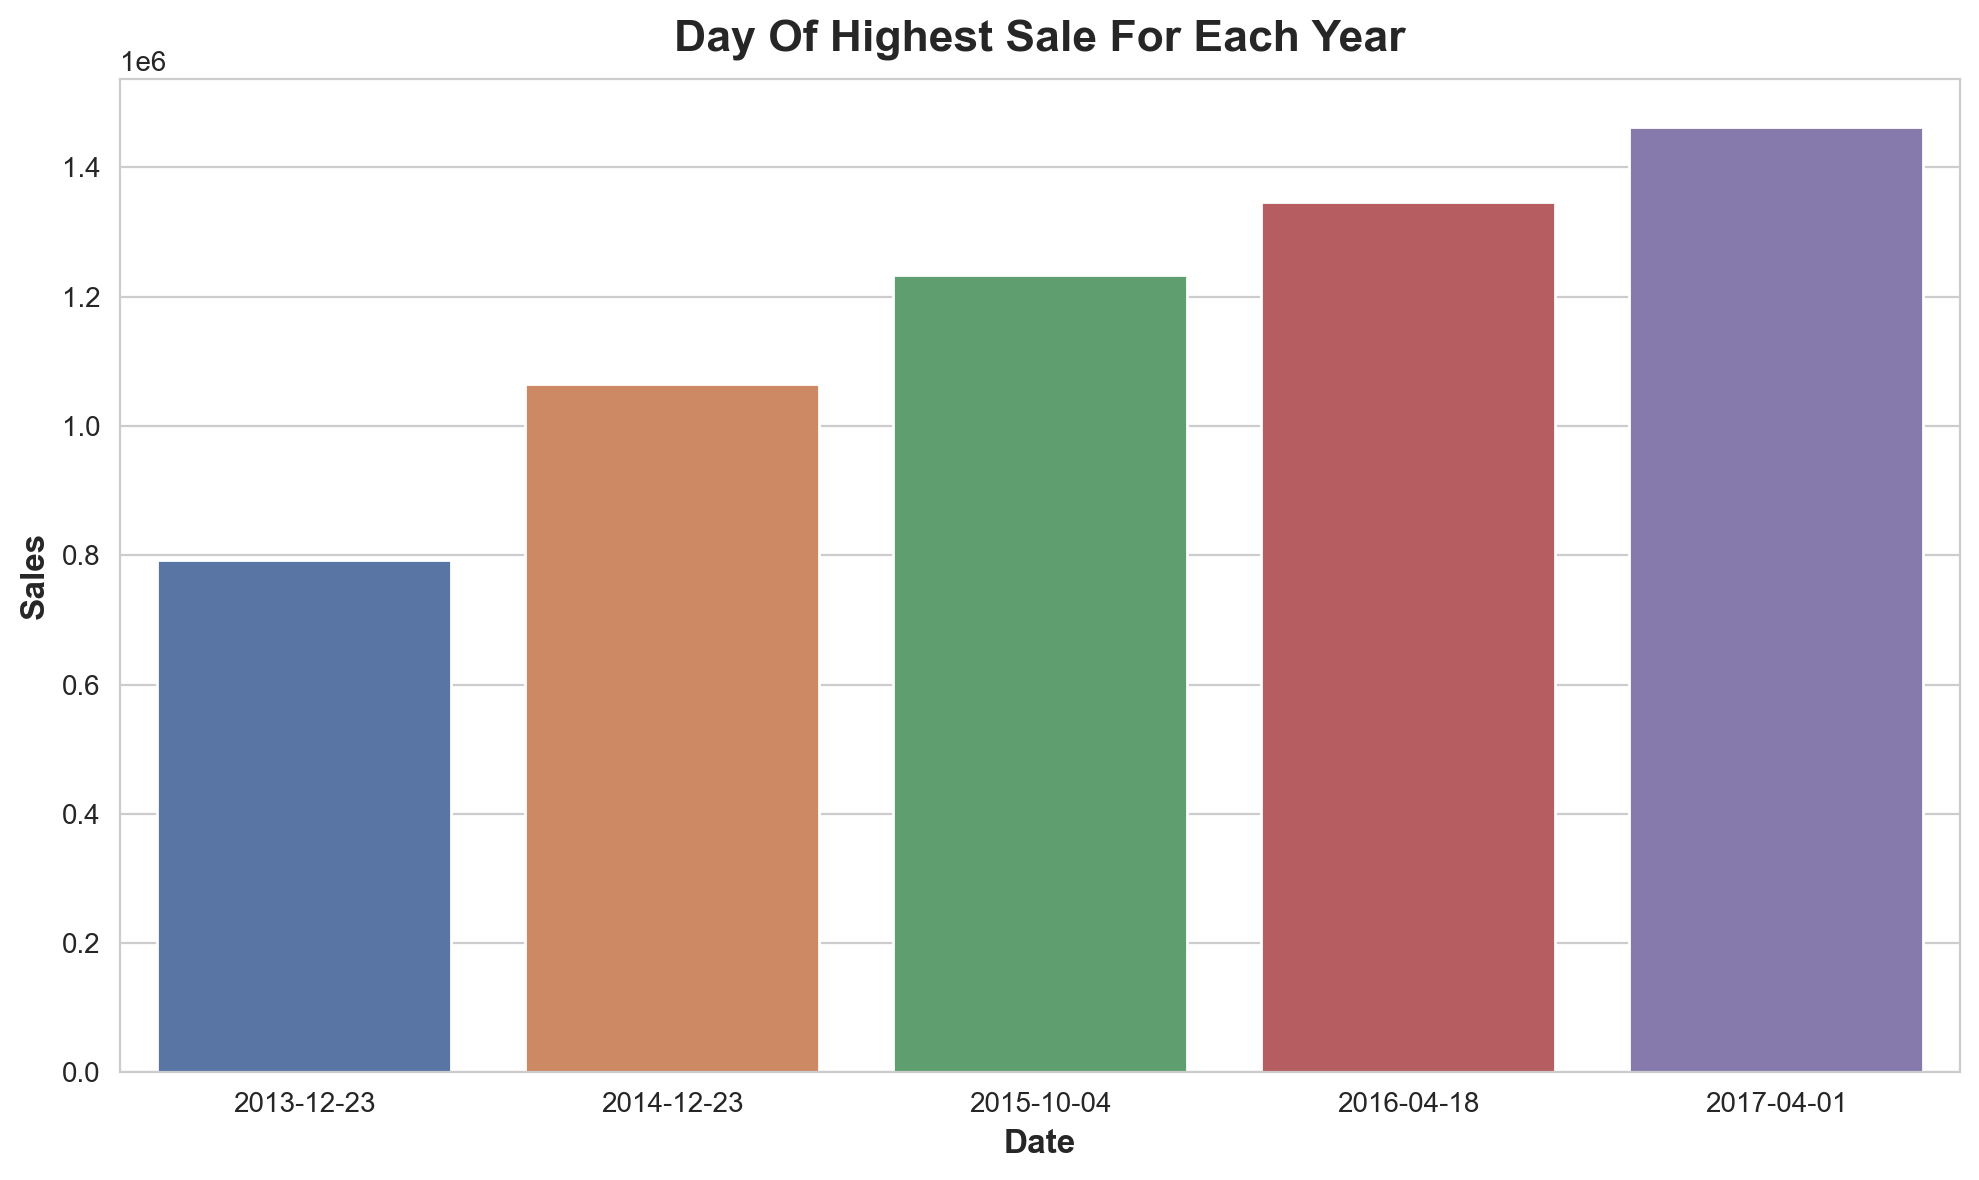

In [265]:
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.barplot(
    x="Date", 
    y="Highest Sale", 
    data=highest_sale_df.reset_index(), 
    hue="Date", palette="deep" , legend=False
    )

ax.set(title="Day of Highest sale for each year".title(), ylabel="Sales")
plt.savefig("../reports/figures/highest_sale_dates.png");

why are these days the highest sales days? 

In [289]:
highest_sale_dates = [str(day) for day in highest_sale_df.index.date]
highest_sale_dates

['2013-12-23', '2014-12-23', '2015-10-04', '2016-04-18', '2017-04-01']

In [296]:
for day in highest_sale_dates:
    if day in holiday_events.index:
        print(f"Highest sale day: {day}")
        print(f"{holiday_events.loc[day]}")
        print("")

Highest sale day: 2013-12-23
type           Additional
locale           National
locale_name       Ecuador
description     Navidad-2
transferred         False
Name: 2013-12-23 00:00:00, dtype: object

Highest sale day: 2014-12-23
type           Additional
locale           National
locale_name       Ecuador
description     Navidad-2
transferred         False
Name: 2014-12-23 00:00:00, dtype: object

Highest sale day: 2016-04-18
type                        Event
locale                   National
locale_name               Ecuador
description    Terremoto Manabi+2
transferred                 False
Name: 2016-04-18 00:00:00, dtype: object

Highest sale day: 2017-04-01
type                                 Holiday
locale                              Regional
locale_name                         Cotopaxi
description    Provincializacion de Cotopaxi
transferred                            False
Name: 2017-04-01 00:00:00, dtype: object



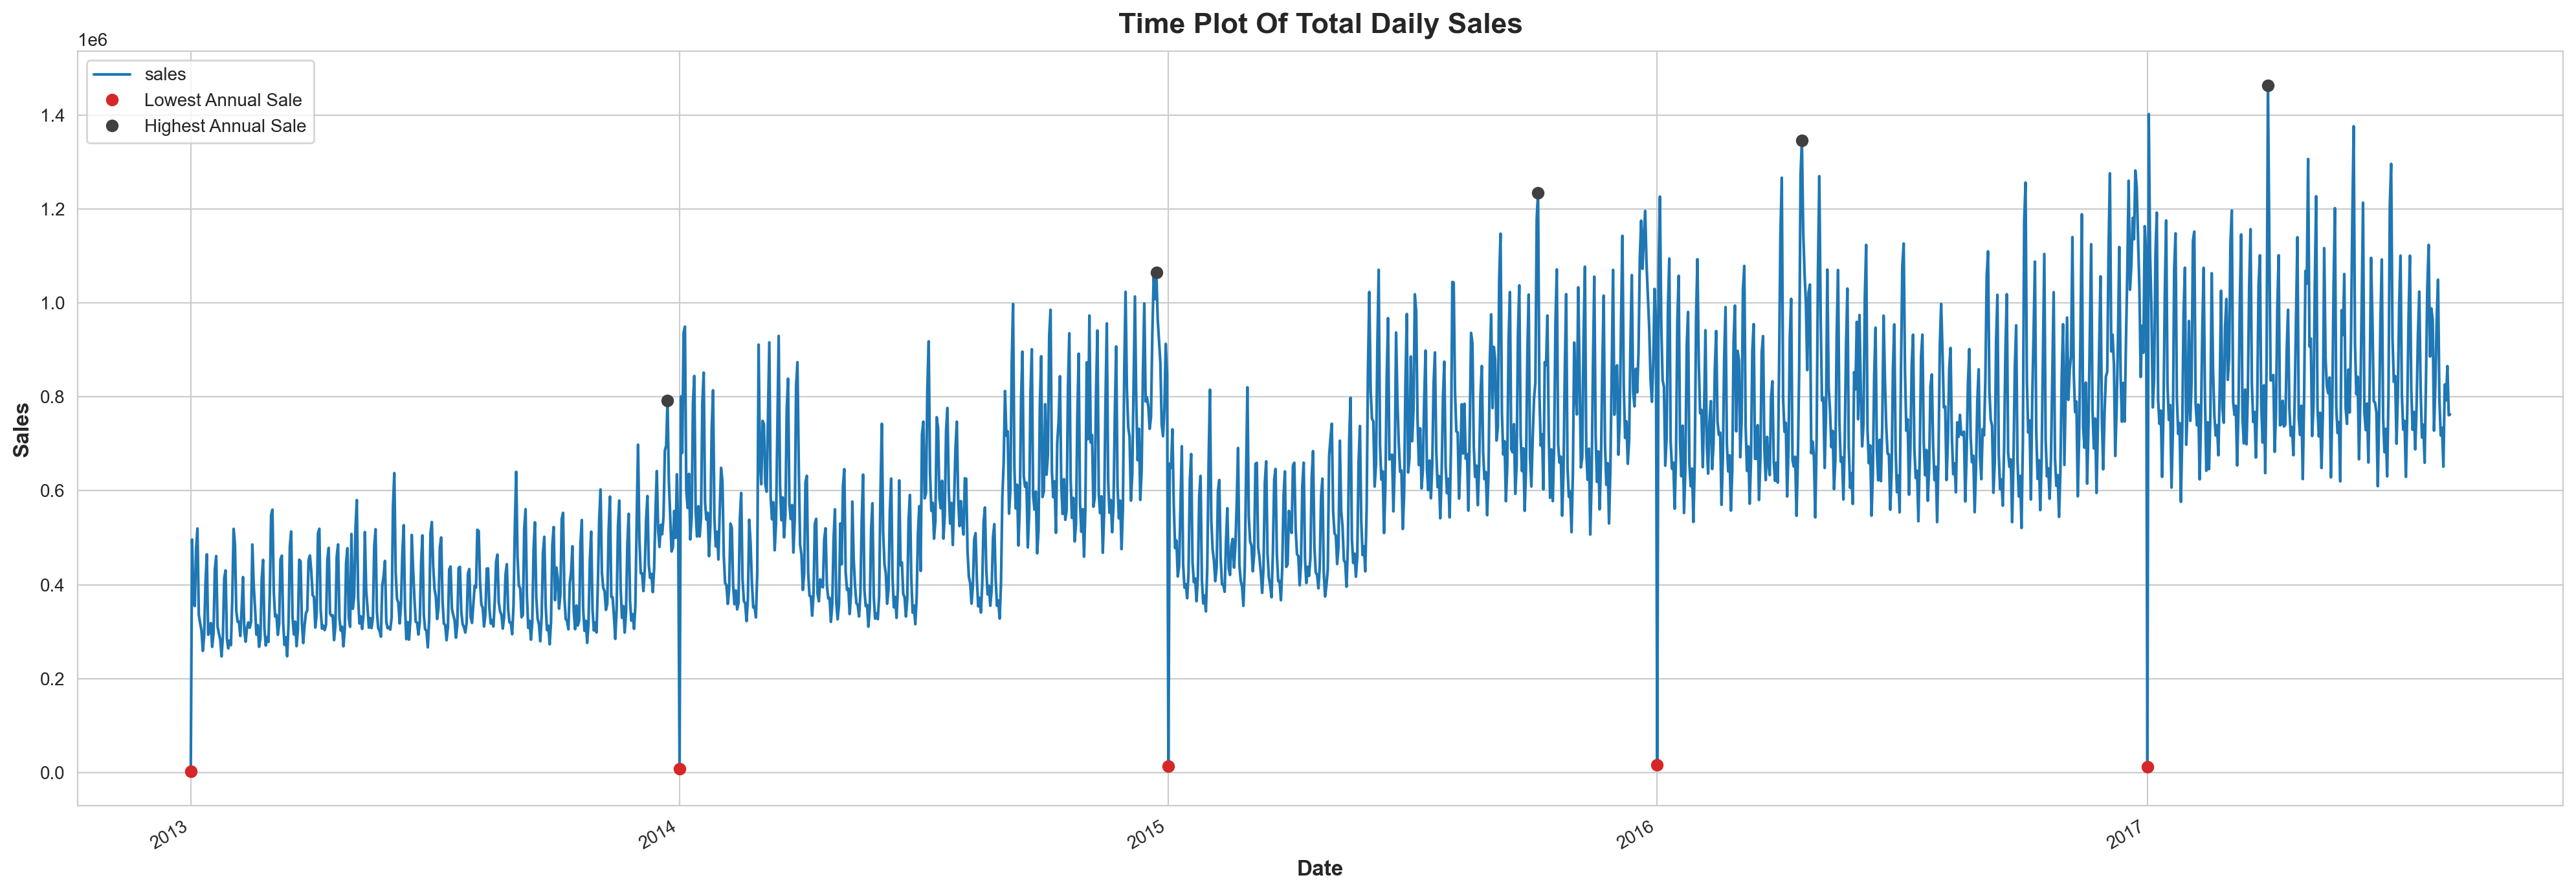

In [268]:
## visualize the lowest and highest sale dates for year on a time plot

fig, ax = plt.subplots()

ax = total_daily_sales.plot()
ax.plot(lowest_sales_df.index, 
        lowest_sales_df["Lowest Sale"], 
        marker="o", linestyle="", color="C3", label="Lowest Annual Sale")
ax.plot(highest_sale_df.index, 
        highest_sale_df["Highest Sale"], 
        marker="o", linestyle="", color="0.25", label="Highest Annual Sale")
ax.set(title="Time plot of total daily sales".title(), ylabel="Sales", xlabel="Date" )
ax.legend()
plt.savefig("../reports/figures/Time plot of total daily sales.png");

2. Did the earthquake impact sales?


<Axes: xlabel='date'>

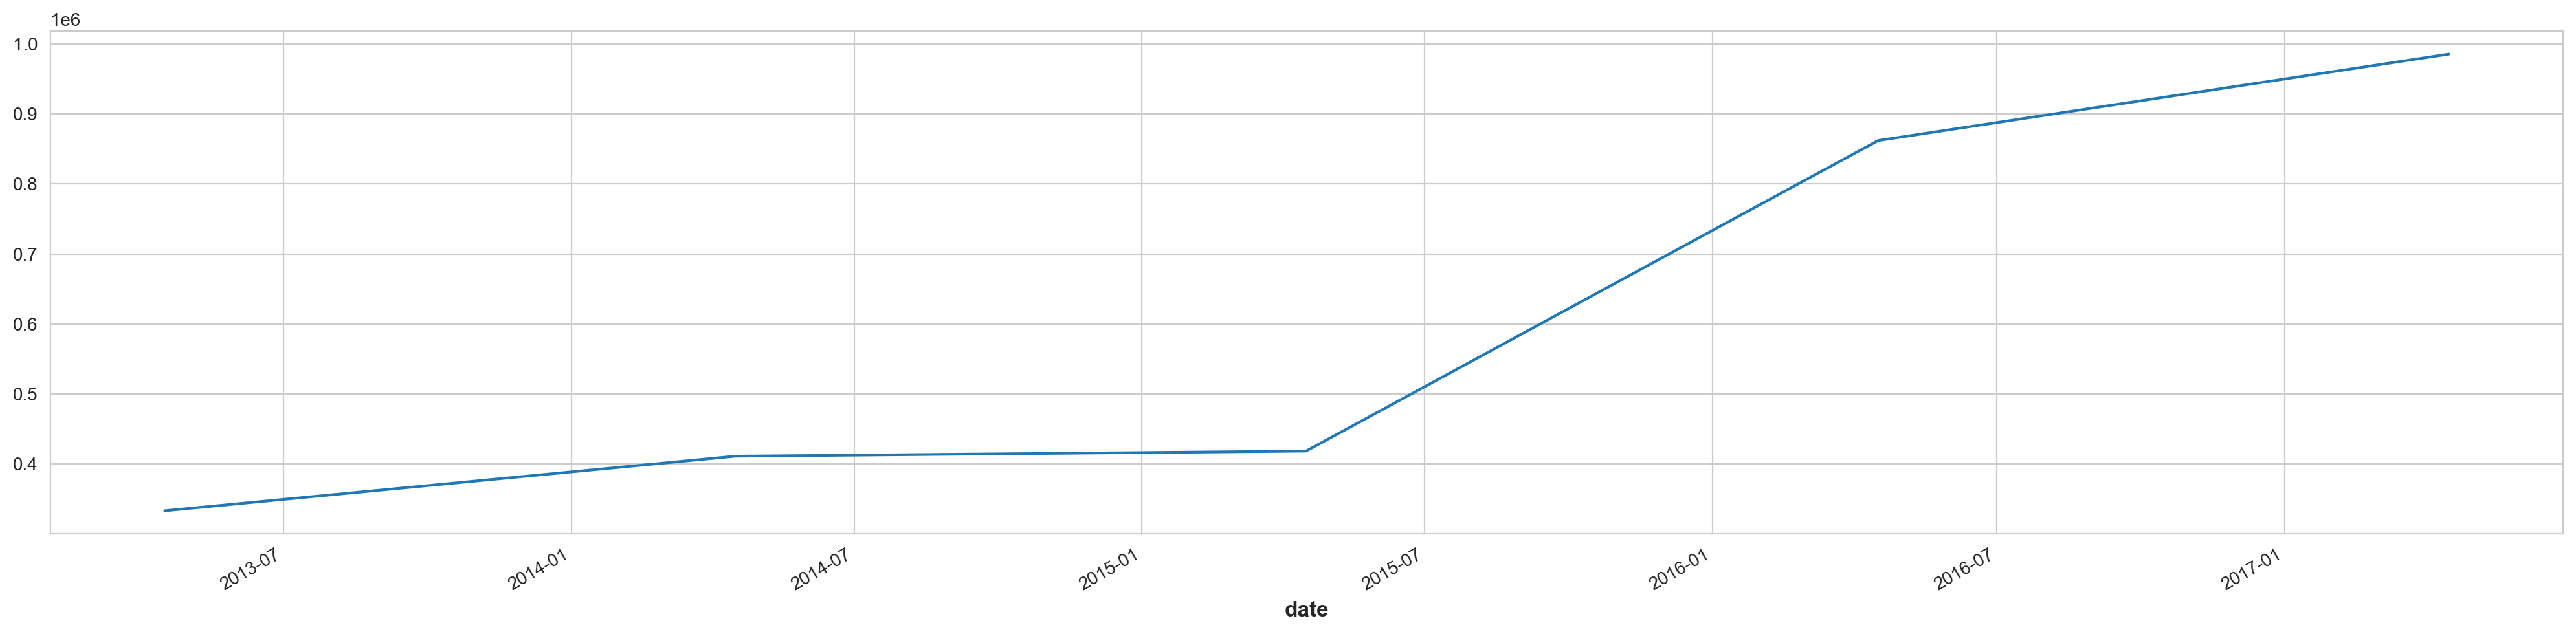

In [55]:
day_of_earthquake = pd.Timestamp("2016-04-16")
total_daily_sales[["2013-04-16", "2014-04-16", "2015-04-16", "2016-04-16", "2017-04-16"]]

<Axes: xlabel='date'>

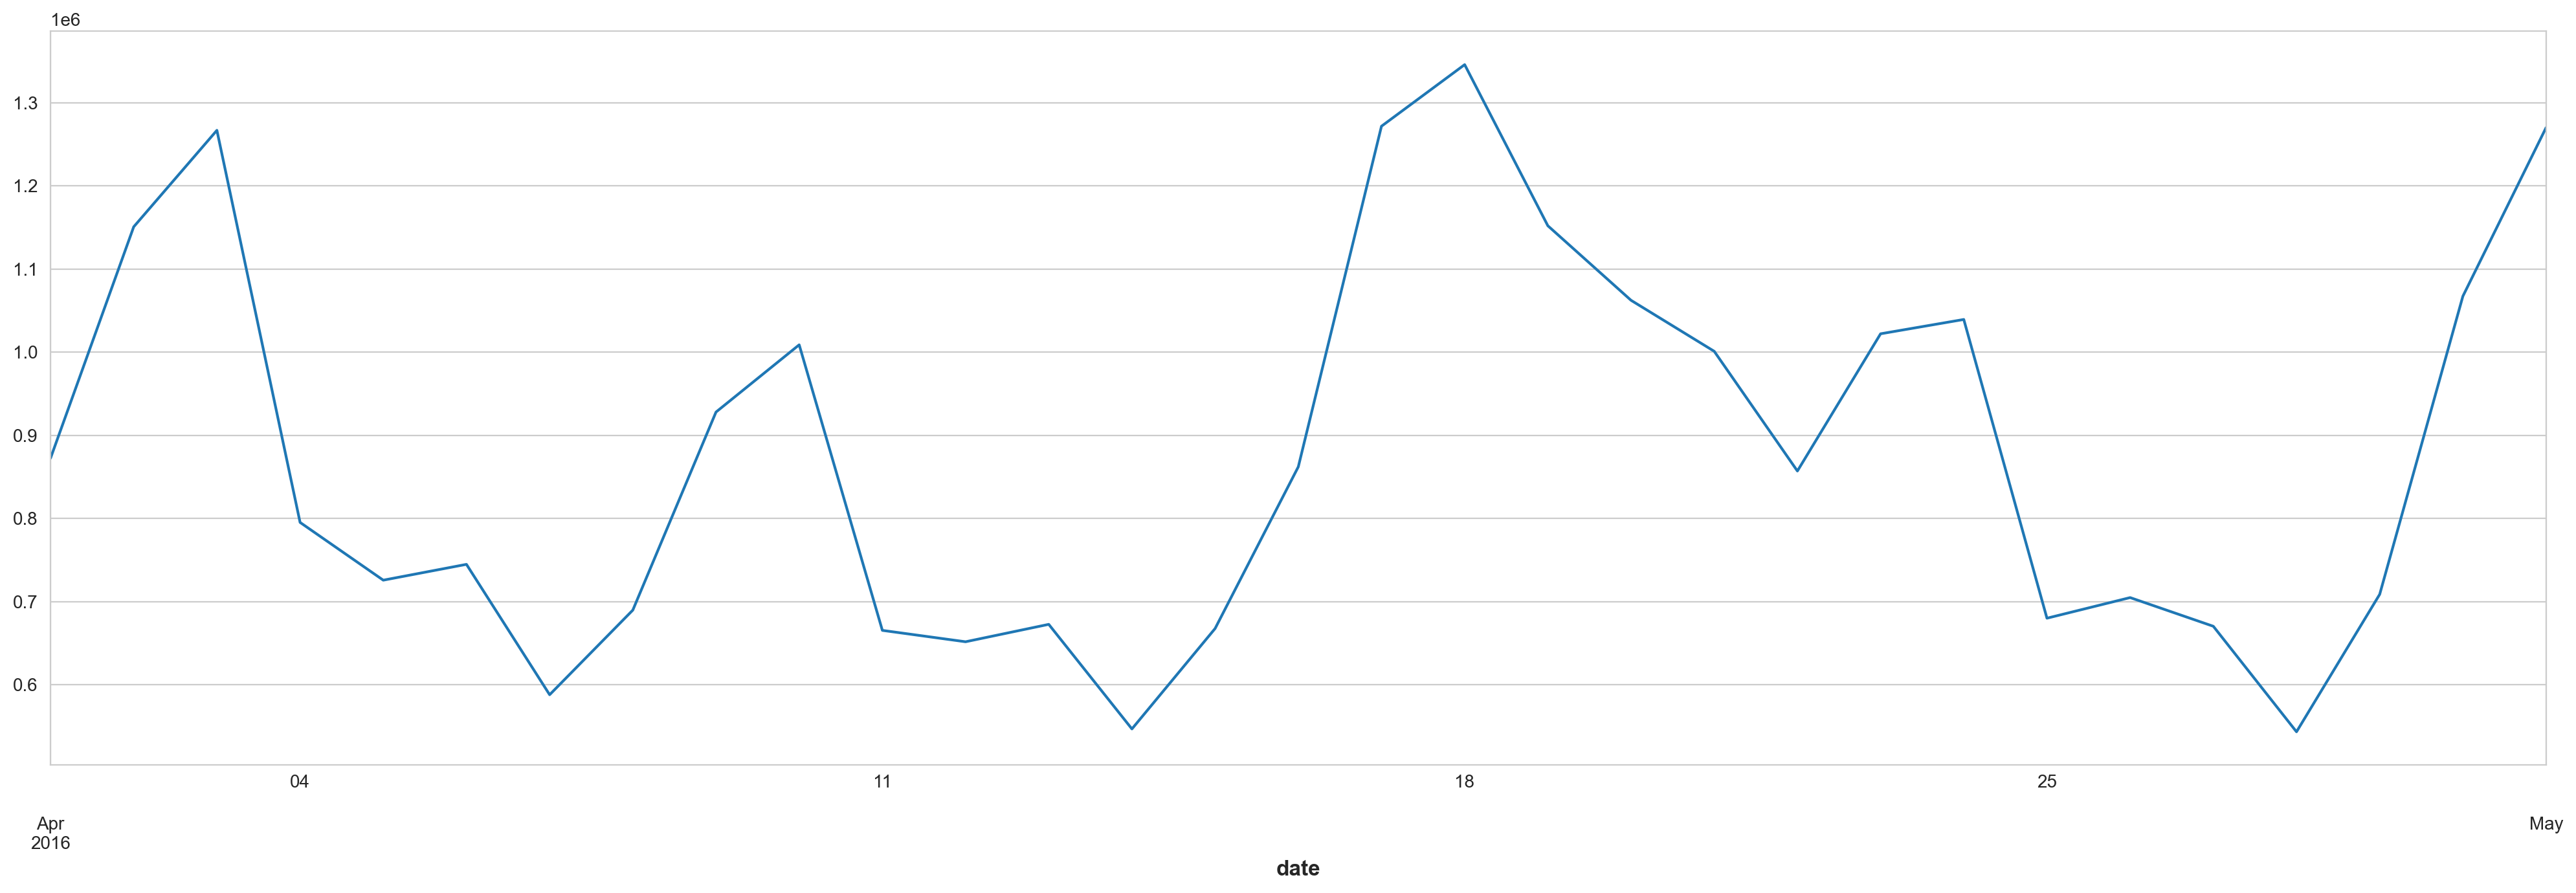

In [297]:
total_daily_sales[ "2016-04-01":"2016-05-01"].plot();

3. Are certain groups of stores selling more products? (Cluster, city, state, type)


In [132]:
## merge train with stores 

train_stores_df = train.reset_index().merge(right=stores, how="inner", on="store_nbr")
train_stores_df = train_stores_df.drop(columns=["id"]).set_index('date')

train_stores_df

,store_nbr,family,sales,onpromotion,city,state,type,cluster
date,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13
2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13
2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13
2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13
2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...
2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6
2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6
2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6


In [237]:
## cal total sales according to cluster

cluster_df = train_stores_df.groupby( [train_stores_df.index.year, "cluster"], observed=True )["sales"]\
               .sum().to_frame()
cluster_df

sales
date cluster              
2013 1        7.789934e+06
     10       9.523252e+06
     11       1.128405e+07
     12       2.334356e+06
     13       8.306503e+06
...                    ...
2017 5        1.049012e+07
     6        2.190492e+07
     7        3.384504e+06
     8        1.874111e+07
     9        5.032333e+06

[85 rows x 1 columns]

In [253]:
## extract top 5 clusters accross years. 

top5_cluster_df = cluster_df.groupby("date")['sales']\
                                     .nlargest(5)\
                                     .reset_index(level=0, drop=True)\
                                     .reset_index(level=1)
top5_cluster_df.reset_index(inplace=True)                                     
top5_cluster_df.cluster = top5_cluster_df.cluster.astype(int)

In [254]:
used_clusters = sorted(top5_cluster_df.cluster.unique().tolist())
used_clusters

[3, 6, 8, 10, 11, 14]

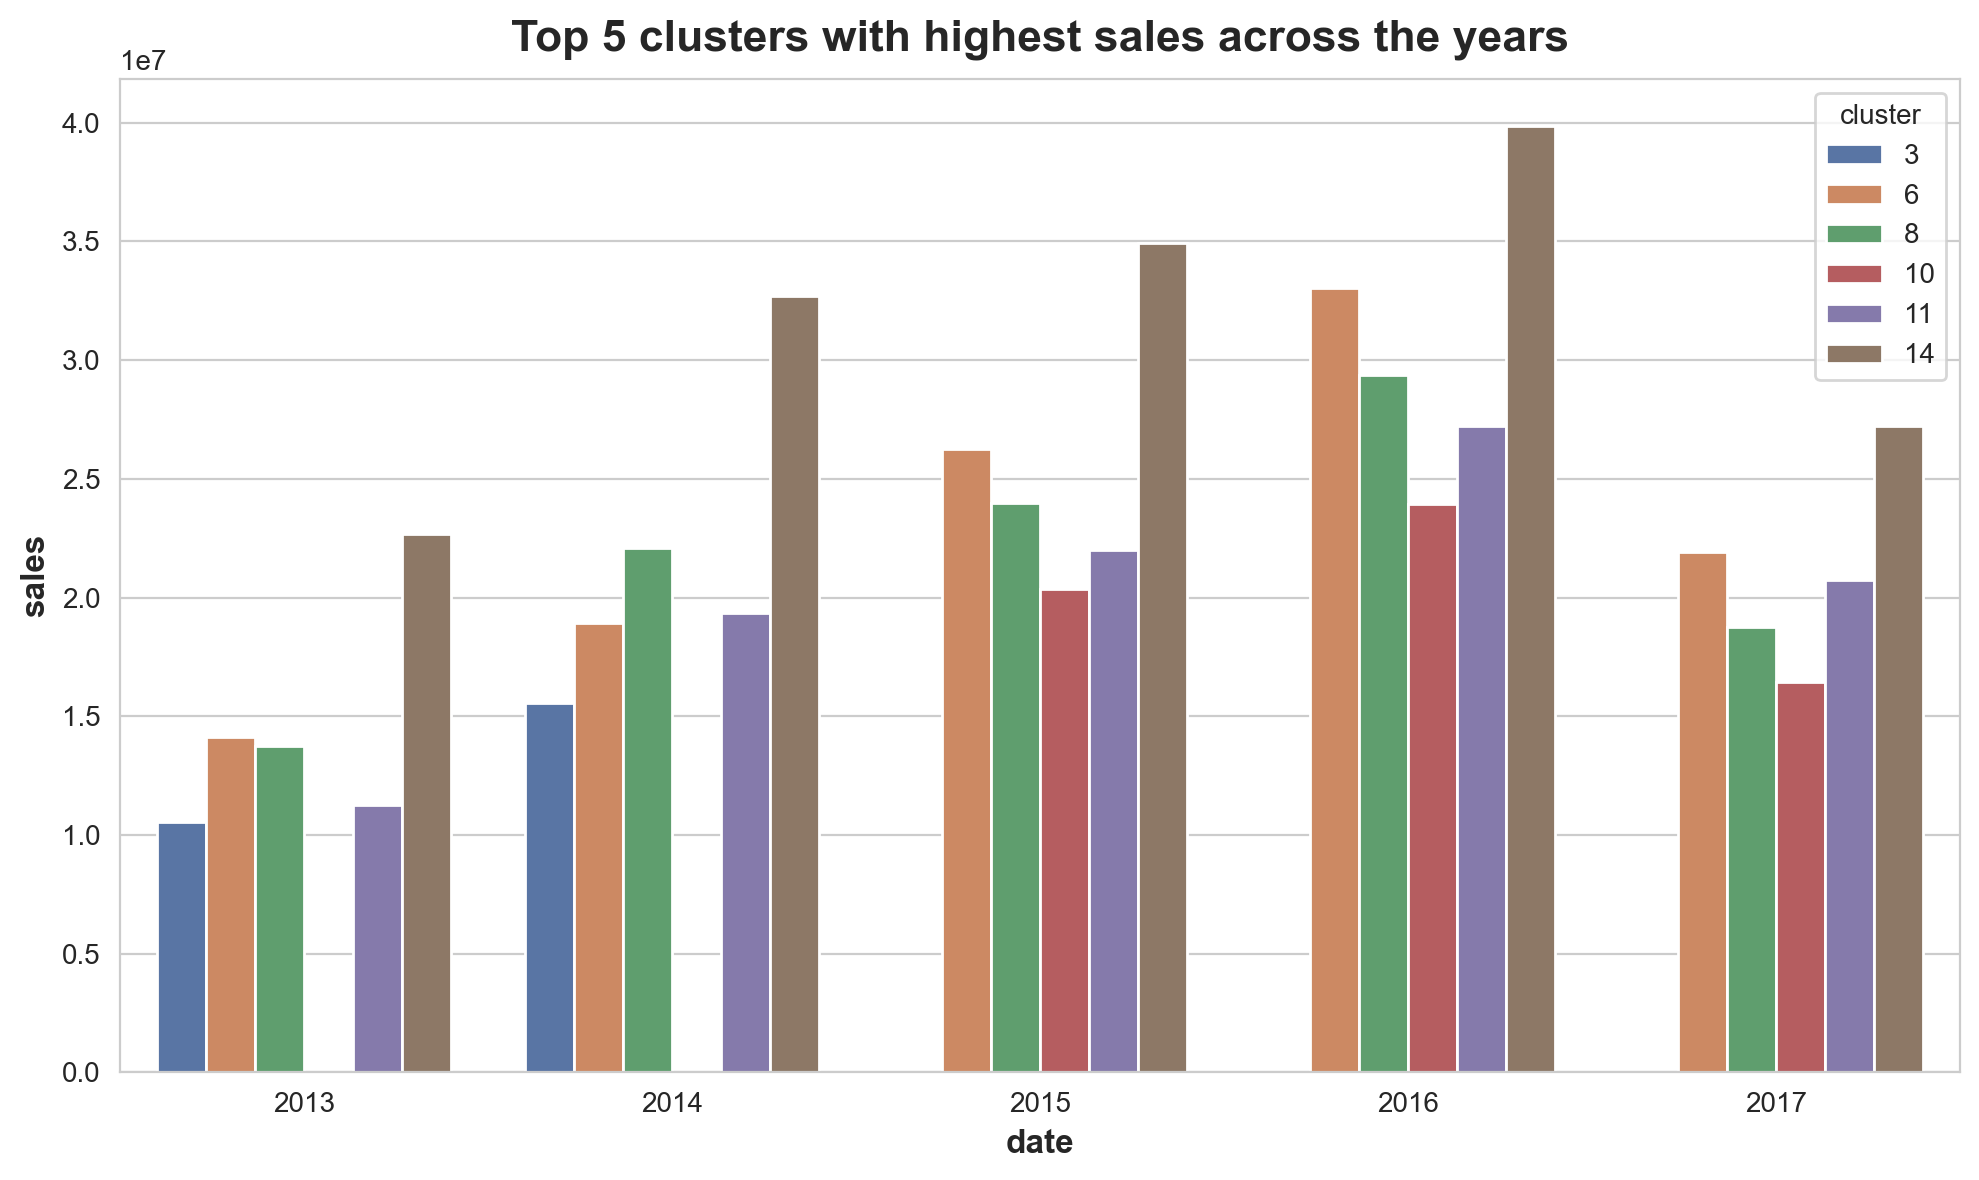

In [259]:
## plot top 5 clusters with highest sales   
   
fig, ax = plt.subplots(figsize=(10, 6))

ax = sns.barplot(data=top5_cluster_df, x="date", y="sales",
                 hue="cluster", hue_order=used_clusters, palette="deep", legend=True);

# Add text labels to the bars
#for p in ax.patches:
#    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
#                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add cluster labels to the bars



ax.set_title("Top 5 clusters with highest sales across the years")
plt.savefig("../reports/figures/top5_clusters.png");

4. Are sales affected by promotions, oil prices and holidays?